In [1]:
import singing_mouse_aux_functions as aux_functions
from song_modulation import *
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.cluster import AgglomerativeClustering

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Coarse binning parameters
p = dict()
p['pre_length'] = 20
p['post_length'] = 50
p['bin_length'] = 0.5

#Finner binning parameters
p2 = dict()
p2['pre_length'] = 20
p2['post_length'] = 80
p2['bin_length'] = 0.01

smoothing_dict={'cutoff_range':100,'sigma':0.2}

# Data_dir_list
data_dir_list=['../Data/190716/','../Data/190711/','../Data/190724/','../Data/190709/','../Data/190516/','../Data/190523/','../Data/190521/','../Data/200919/','../Data/200917/','../Data/191217/','../Data/190705/','../Data/190708/','../Data/191223/']

In [3]:
#load sessions
session_list=[]
for data_dir in tqdm(data_dir_list):
    session_list.append(session_song_modulation(data_dir,p,p2,smoothing_dict))

100%|██████████| 13/13 [10:18<00:00, 47.54s/it]


In [4]:
#perform warping analysis
results=[]
wpa_list=[]
for s in tqdm(session_list):
    wpa=warping_analysis(s)
    results.extend(wpa.warping(metrics='correlation',low_lim=0.4,high_lim=2.5,bin_num=31))
    wpa_list.append(wpa)

  0%|          | 0/13 [00:00<?, ?it/s]/home/ubuntu/NNSingingMouse/Notebooks/song_modulation.py:360: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.cluster_list = np.array(cluster_list)[reindex]
 69%|██████▉   | 9/13 [00:18<00:08,  2.16s/it]

No enough clusters for../Data/191217/


100%|██████████| 13/13 [00:20<00:00,  1.54s/it]


In [5]:
behav_scaling=np.concatenate(np.array(results)[:,-1])
neural_scaling=np.concatenate(np.array(results)[:,-2])

<ipython-input-5-04ef53d99b41>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  behav_scaling=np.concatenate(np.array(results)[:,-1])
<ipython-input-5-04ef53d99b41>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  neural_scaling=np.concatenate(np.array(results)[:,-2])


In [6]:
bins=np.linspace(0.5,1,11)
x_list=[]
y_list=[]
for i in range(len(bins)-1):
    index=np.where((behav_scaling>bins[i])*(behav_scaling<bins[i+1]))[0]
    x_list.append(behav_scaling[index])
    y_list.append(neural_scaling[index])
#bootstrap to estimate the standard error of the median
n_b=10000
std_list=[]
for y_i in y_list:
    tempt_list=[]
    for _ in range(n_b):
        tempt_list.append(np.median(np.random.choice(y_i,len(y_i),replace=True)))
    std_list.append(np.std(tempt_list))

/home/ubuntu/anaconda3/envs/python38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/envs/python38/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'Optimal neural scaling')

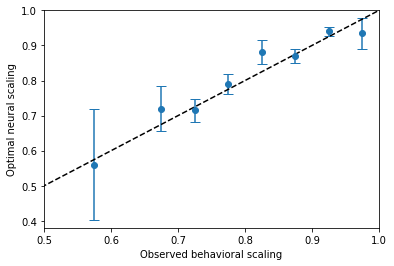

In [7]:
plt.errorbar(bins[:-1]+(bins[1]-bins[0])/2,[np.median(i) for i in y_list],
             yerr = std_list , ls='none',marker='o',capsize=5)
plt.plot([0.1,1.1],[0.1,1.1],'k--')
plt.xlim([0.5,1.0])
plt.ylim([0.38,1.0])
plt.xlabel('Observed behavioral scaling')
plt.ylabel('Optimal neural scaling')

In [8]:
from sklearn.linear_model import QuantileRegressor
qr = QuantileRegressor(quantile=0.5, alpha=0,fit_intercept=False)
qr.fit(behav_scaling.reshape(-1,1),neural_scaling)

QuantileRegressor(alpha=0, fit_intercept=False)

0.8200000000000004 0.820957210939873


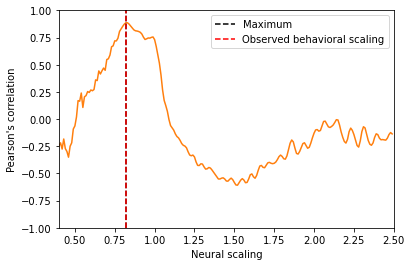

In [9]:
i=-1
probe_neuron=2
plt.plot(results[probe_neuron][1][i],-np.array(results[probe_neuron][0][i]),color='#ff7f0e')#'#2ca02c')
plt.ylim(-1,1)
tempt=plt.ylim()
x=results[probe_neuron][1][i][np.array(results[probe_neuron][0][i]).argmin()]
plt.plot([x,x],tempt,'k--',label='Maximum')
plt.plot([results[probe_neuron][-1][i],results[probe_neuron][-1][i]],tempt,'r--',label='Observed behavioral scaling')
plt.ylabel('Pearson\'s correlation')
plt.legend()
plt.xlabel('Neural scaling')
plt.xlim(0.4,2.5)
print(x,results[probe_neuron][-1][i])

Text(0.5, 1.0, 'Unit 4')

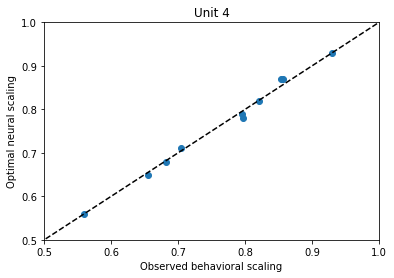

In [10]:
plt.scatter(results[probe_neuron][-1],results[probe_neuron][-2])
plt.plot([0,1],[0,1],'k--')
plt.xlim(0.5,1)
plt.ylim(0.5,1)
plt.xlabel('Observed behavioral scaling')
plt.ylabel('Optimal neural scaling')
plt.title('Unit 4')

In [11]:
def make_interp1d_psth2(all_sing_time_psth_s,bin_vec_s):
    song_num=all_sing_time_psth_s.shape[0]
    neuron_num=all_sing_time_psth_s.shape[2]
    inter_func=[]
    for neuron_i in range(neuron_num):
        tmept_list=[]
        for song_i in range(song_num):
            tmept_list.append(interp1d(bin_vec_s,all_sing_time_psth_s[song_i,:,neuron_i]))
        inter_func.append(tmept_list)
    return inter_func

In [12]:
rex_ab_list=[]
rex_list=[]
rex_c_list=[]
FR_inside_list=[]
meta_y=[]
meta_y_ab=[]
for session_i in range(13):
    inter_func2=make_interp1d_psth2(session_list[session_i].all_sing_time_psth_s,session_list[session_i].bin_vec_s)
    sample_x=np.linspace(0,1,int(session_list[session_i].song_length_array.min()*5))
    for probe_neuron in session_list[session_i].neuron_modulation_list:
        y=[]
        y_c=[]
        for i,func in enumerate(inter_func2[probe_neuron]):
            y.append(func(sample_x*session_list[session_i].song_length_array[i]))  
            y_c.append(func(30+sample_x*session_list[session_i].song_length_array[i]))  
        y=np.array(y)
        y_c=np.array(y_c)
        FR_inside_list.append(y.mean())
        rex_c_list.append(1-((y_c-y_c.mean(axis=0,keepdims=True))**2).mean()/np.var(y_c))
        rex_list.append(1-((y-y.mean(axis=0,keepdims=True))**2).mean()/np.var(y))
        meta_y.append(y)
    for probe_neuron in session_list[session_i].neuron_modulation_list:
        y=session_list[session_i].all_sing_time_psth_s[:,2000:2000+int(session_list[session_i].song_length_array.min()*100):20,probe_neuron]
        rex_ab_list.append(1-((y-y.mean(axis=0,keepdims=True))**2).mean()/np.var(y))
        meta_y_ab.append(y)
rex_ab_list=np.array(rex_ab_list)
rex_list=np.array(rex_list)

Text(0, 0.5, 'Explained variance (Relative Time)')

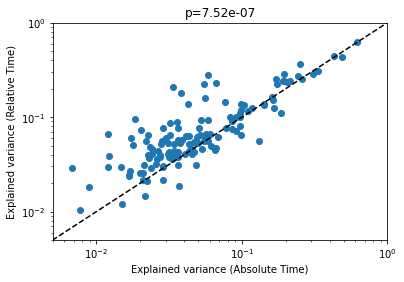

In [13]:
plt.scatter(rex_ab_list,rex_list)
plt.title('p=%1.2e'%(ttest_rel(rex_ab_list,rex_list)[1]*2))
plt.xlim(0.005,1.0)
plt.ylim(0.005,1.0)
plt.plot([0,1],[0,1],'k--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Explained variance (Absolute Time)')
plt.ylabel('Explained variance (Relative Time)')

In [14]:
#cross_validation_version
rex_ab_list=[]
rex_list=[]
for session_i in range(13):
    inter_func2=make_interp1d_psth2(session_list[session_i].all_sing_time_psth_s,session_list[session_i].bin_vec_s)
    sample_x=np.linspace(0,1,int(session_list[session_i].song_length_array.min()*5))
    for probe_neuron in session_list[session_i].neuron_modulation_list:
        predict_y=[]
        for probe_song in range(session_list[session_i].song_num):
            y=[]
            for i,func in enumerate(inter_func2[probe_neuron]):
                if i!=probe_song:
                    y.append(func(sample_x*session_list[session_i].song_length_array[i]))  
            y=np.array(y)
            predict_y.append(y.mean(axis=0))
        y=[]
        for i,func in enumerate(inter_func2[probe_neuron]):
            y.append(func(sample_x*session_list[session_i].song_length_array[i]))  
        rex_list.append(1-((np.array(predict_y)-y)**2).mean()/np.var(y))
    for probe_neuron in session_list[session_i].neuron_modulation_list:
        y=session_list[session_i].all_sing_time_psth_s[:,2000:2000+int(session_list[session_i].song_length_array.min()*100):20,probe_neuron]
        predict_y=[]
        for probe_song in range(session_list[session_i].song_num):
            ind=list(np.arange(session_list[session_i].song_num))
            ind=list(set(ind)-set([probe_song]))
            predict_y.append(y[ind].mean(axis=0))
        rex_ab_list.append(1-((y-np.array(predict_y))**2).mean()/np.var(y))
rex_ab_list=np.array(rex_ab_list)
rex_list=np.array(rex_list)

Text(0, 0.5, '$r^2$ (Relative Time)')

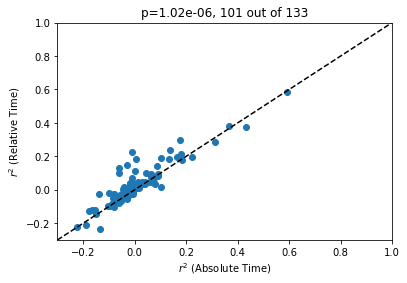

In [15]:
plt.scatter(rex_ab_list,rex_list)
plt.title('p=%1.2e, %d out of %d'%(ttest_rel(rex_ab_list,rex_list)[1]*2,(rex_list>rex_ab_list).sum(),len(rex_list)))
plt.plot([-0.3,1],[-0.3,1],'k--')
plt.xlim(-0.3,1)
plt.ylim(-0.3,1)
plt.xlabel(r'$r^2$ (Absolute Time)')
plt.ylabel(r'$r^2$ (Relative Time)')

In [16]:
#negelect 191217 session
session_list2=np.array(session_list)[[0,1,2,3,4,5,6,7,8,10,11,12]]
FR_t=1
meta_neuron_selected_data_set_list=[]
meta_neuron_psth=[]
meta_neuron_selected_list=[]
FR_control_list=[]
for s in session_list2:
    FR_control_list.append(s.FR_control)
    FR_condition=np.where((s.FR_within_song>FR_t)+(s.FR_control>FR_t))[0]
    selected_neuron=combine_selection(FR_condition,s.neuron_modulation_list)
    inter_func=make_interp1d_psth_single(s.all_sing_time_psth_s,s.bin_vec_s)
    for neuron_id in selected_neuron:
        sample_x=np.linspace(-1,2,301)
        y=[]
        for i,func in enumerate(inter_func[neuron_id]):
            y.append(func(sample_x*s.song_length_array[i]))  
        y=np.array(y)
        meta_neuron_psth.append(y)
        meta_neuron_selected_data_set_list.append(data_dir)
    meta_neuron_selected_list.append(selected_neuron)
FR_control_list=np.array(FR_control_list)

<ipython-input-16-8072e64c458b>:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  FR_control_list=np.array(FR_control_list)


In [17]:
meta_neuron_psth=np.array(meta_neuron_psth)
mean_psth=np.array([i.mean(axis=0) for i in meta_neuron_psth])
std_psth=np.array([i.std(axis=0)/np.sqrt(len(i)-1) for i in meta_neuron_psth])
X = (mean_psth-mean_psth.mean(axis=1,keepdims=True))/mean_psth.std(axis=1,keepdims=True)

<ipython-input-17-1fb0a6cd03d7>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  meta_neuron_psth=np.array(meta_neuron_psth)


In [18]:
choice=np.arange(80,221,1)
clustering = AgglomerativeClustering(n_clusters=8,compute_full_tree=True,linkage='ward').fit(X[:,choice])
c=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#030764', '#bcbd22', '#17becf','yellow','maroon','darkblue','gold','#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

In [19]:
cluster_list=[]
order_list=[]
number_cluster_list=[]

for i in [[3],[7],[1],[6],[4],[0],[5],[2]]:
    index_cluster=[]
    for ii in i:
        index_cluster.extend(np.where(clustering.labels_==ii)[0])
    cluster_list.append(index_cluster)
    argmax_list=[]
    for j in index_cluster:
        argmax_list.append(X[j][100:201].argmax())
    order_list.append(np.array(index_cluster))
    number_cluster_list.append(len(index_cluster))

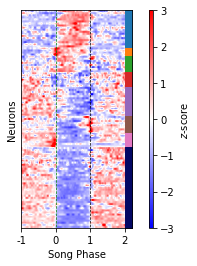

In [20]:
order_list=np.concatenate(order_list)
num_for_plot=np.repeat([0]+list(np.cumsum(number_cluster_list)),2)[1:-1].reshape(-1,2)
plt.imshow(X[order_list],aspect=6.0,cmap='bwr',vmin=-3,vmax=3)
plt.yticks([])
plt.xlim(0,321)
plt.xticks([0,100,200,300],labels=[-1,0,1,2])
plt.xlabel('Song Phase')
plt.ylabel('Neurons')
for cl,(i,j) in enumerate(num_for_plot):
    plt.fill_between([301,321],[i-0.5,i-0.5],[j-0.5,j-0.5],
                     color=c[cl])
plt.plot([100,100],[-1,len(X)+1],'g--',linewidth=.7)
plt.plot([200,200],[-1,len(X)+1],'k--',linewidth=.7)
plt.ylim(len(X)-0.5,-0.5)
plt.colorbar(label='$z$-score',aspect=50)